In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import seaborn as sns
sns.set(rc={"axes.facecolor":"Beige" , "axes.grid" : False})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import math
# Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [93]:
df = pd.read_csv("EU_energy_data.csv")
df.head()

,Unnamed: 0,fecha,hora,sistema,bandera,precio,tipo_moneda,origen_dato,fecha_actualizacion
0,0,2010-07-21,1,HU,1,39.2870,1,6,2021-10-01 12:39:53
1,1,2010-07-21,2,HU,1,35.9250,1,6,2021-10-01 12:39:53
2,2,2010-07-21,3,HU,1,33.2230,1,6,2021-10-01 12:39:53
3,3,2010-07-21,4,HU,1,30.8420,1,6,2021-10-01 12:39:53
4,4,2010-07-21,5,HU,1,33.3950,1,6,2021-10-01 12:39:53


In [94]:
df = df.rename(columns = {
    'fecha': 'Date',
    'hora': 'Hour',
    'sistema': 'EU_countries',
    'bandera': 'Renewable/Non_Renewable',
    'precio': 'Cost(€/MWh)',
    'tipo_moneda': 'CurrencyType',
    'origen_dato': 'DataSource',
    'fecha_actualizacion': 'Updated_Date'
})
df.head()

,Unnamed: 0,Date,Hour,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,0,2010-07-21,1,HU,1,39.2870,1,6,2021-10-01 12:39:53
1,1,2010-07-21,2,HU,1,35.9250,1,6,2021-10-01 12:39:53
2,2,2010-07-21,3,HU,1,33.2230,1,6,2021-10-01 12:39:53
3,3,2010-07-21,4,HU,1,30.8420,1,6,2021-10-01 12:39:53
4,4,2010-07-21,5,HU,1,33.3950,1,6,2021-10-01 12:39:53


In [95]:
df = df.drop('Unnamed: 0',axis=1)
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Hour'] = df['Hour'].astype(str).str.zfill(2)
try:
  df['Hour'] = pd.to_numeric(df['Hour'])
except:
  # Handle conversion errors (e.g., non-numeric characters)
  print("Error converting 'Hour' column to numeric")
# Function to convert the range
def convert_range(value):
# Handle edge cases (leading zero and exceeding 24)
   if value == '01':
      return 0
   elif value > 24:
      raise ValueError("Value exceeds 24")
   else:
      # Remove leading zero (assuming strings) or subtract 1 (assuming integers)
      return int(value) - 1 if isinstance(value, int) else int(value[1:])
# Apply the conversion function
df['Hour'] = df['Hour'].apply(convert_range)
# Function to replace values with leading zeros (handles all cases)
def replace_with_leading_zero(value):
    if 0 <= value <= 23:
       return f"{value:02d}" # Use f-string for consistent formatting
    else:
       raise ValueError(f"Value {value} is outside the range 0-12")

# Apply the function
df['Hour'] = df['Hour'].apply(replace_with_leading_zero)
df['Hour'] = df['Hour'].astype(str) # Ensure Hour is string type
df['Hour'] = df['Hour'] + ':00:00'
df["Period"] = df[["Date","Hour"]].apply(" ".join, axis=1)
df = df [['Period','EU_countries', 'Renewable/Non_Renewable',
'Cost(€/MWh)', 'CurrencyType', 'DataSource', 'Updated_Date']]
df['Period'] = pd.to_datetime(df['Period'],format ="%Y-%m-%d %H:%M:%S" )
df.head()

,Period,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,2010-07-21 00:00:00,HU,1,39.2870,1,6,2021-10-01 12:39:53
1,2010-07-21 01:00:00,HU,1,35.9250,1,6,2021-10-01 12:39:53
2,2010-07-21 02:00:00,HU,1,33.2230,1,6,2021-10-01 12:39:53
3,2010-07-21 03:00:00,HU,1,30.8420,1,6,2021-10-01 12:39:53
4,2010-07-21 04:00:00,HU,1,33.3950,1,6,2021-10-01 12:39:53


Counteries Code: https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Country_codes

In [96]:
#Filtering data set for the spain. 

df['EU_countries'] = df['EU_countries'].replace('ES', 'Spain')
df_Spain = df[df['EU_countries']== "Spain"]
df_Spain.head()

,Period,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
179164,2014-01-01 00:00:00,Spain,0,20.0200,1,1,2021-10-01 12:39:53
179185,2014-01-01 01:00:00,Spain,0,10.3400,1,1,2021-10-01 12:39:53
179206,2014-01-01 02:00:00,Spain,0,5.3500,1,1,2021-10-01 12:39:53
179227,2014-01-01 03:00:00,Spain,0,5.0000,1,1,2021-10-01 12:39:53
179248,2014-01-01 04:00:00,Spain,0,0.5000,1,1,2021-10-01 12:39:53


In [97]:
# Remove the unnecessary feature
df_Spain = df_Spain.drop(['EU_countries','CurrencyType','DataSource','Updated_Date','Renewable/Non_Renewable'],axis=1)
df_Spain.head().style.set_properties(subset=['Period'], **{'background-color': 'pink'})

,Period,Cost(€/MWh)
179164,2014-01-01 00:00:00,20.020000
179185,2014-01-01 01:00:00,10.340000
179206,2014-01-01 02:00:00,5.350000
179227,2014-01-01 03:00:00,5.000000
179248,2014-01-01 04:00:00,0.500000


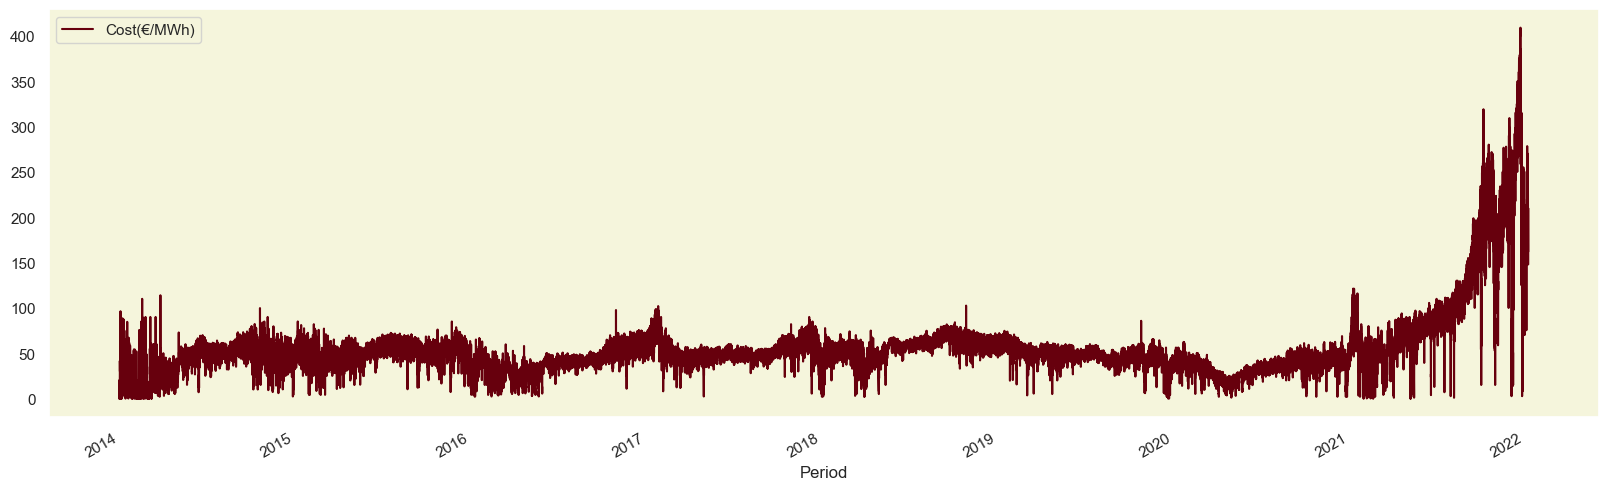

In [98]:
df_Spain.groupby('Period')['Cost(€/MWh)'].agg('sum').plot(legend=True, colormap='Reds_r',figsize = (20, 6));

In [99]:
df_Spain = df_Spain.set_index('Period')
df_Spain.sort_index(inplace=True)
df_Spain.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,20.0200
2014-01-01 01:00:00,10.3400
2014-01-01 02:00:00,5.3500
2014-01-01 03:00:00,5.0000
2014-01-01 04:00:00,0.5000


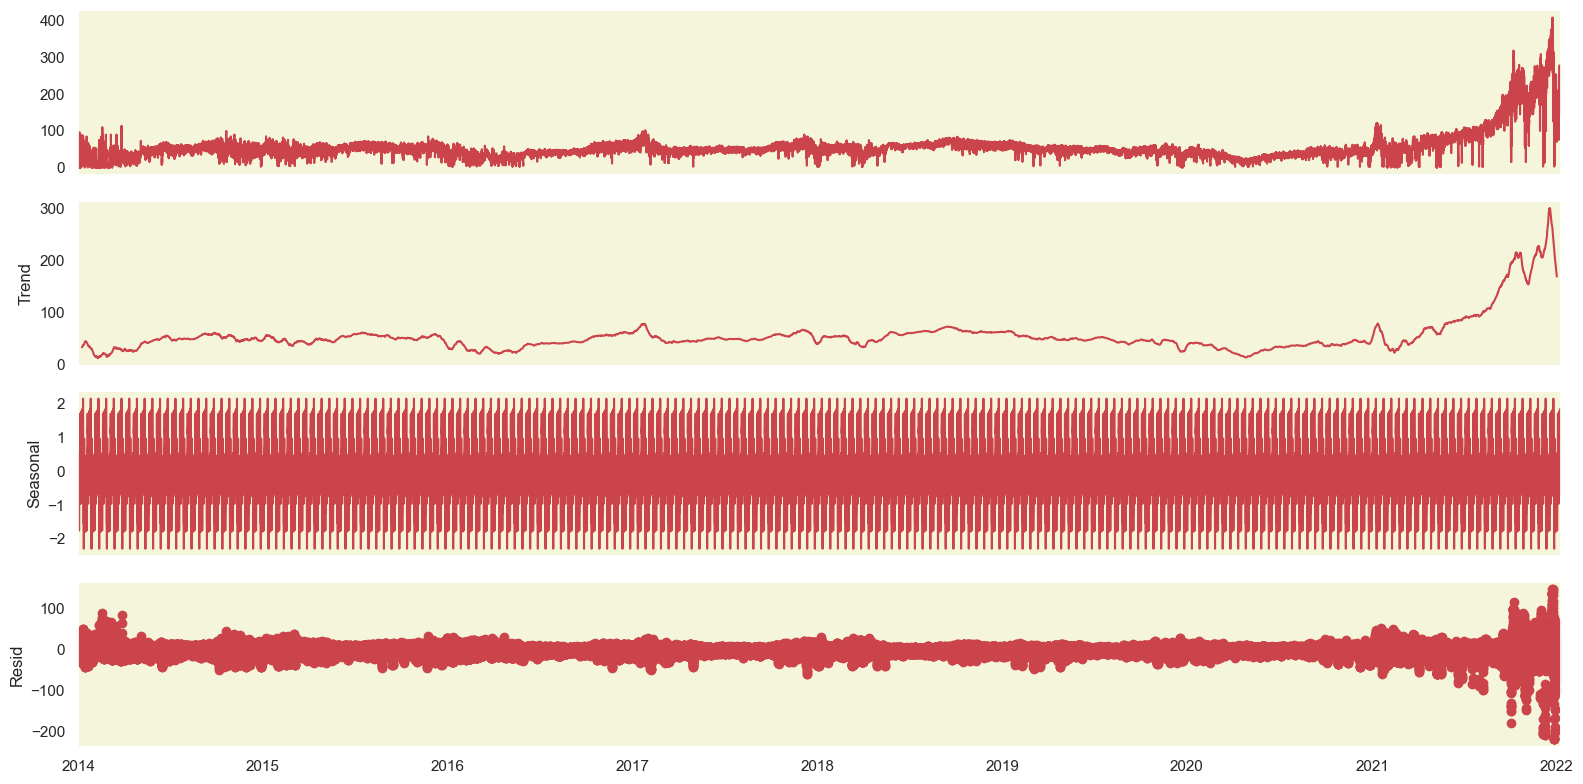

In [100]:
# Set color style
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])
plt.rcParams["figure.figsize"] = (16, 8)
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df_Spain, period=365).plot()
plt.show();


In [101]:
df_Spain1 = df_Spain.reset_index('Period')
# Create new columns for year, quarter, month, and day
df_Spain1['year'] = df_Spain1['Period'].apply(lambda x: x.year)
df_Spain1['quarter'] = df_Spain1['Period'].apply(lambda x: x.quarter)
df_Spain1['month'] = df_Spain1['Period'].apply(lambda x: x.month)
df_Spain1['day'] = df_Spain1['Period'].apply(lambda x: x.day)
df_Spain1["Day"] = df_Spain1["Period"].dt.dayofweek
df_Spain1["Hour"] = df_Spain1["Period"].dt.hour
df_Spain1['MonthName'] = df_Spain1['Period'].apply(lambda x : x.month_name())
df_Spain1['weekday'] = df_Spain1['Period'].apply(lambda x: x.weekday() < 5).astype(int)
df_Spain1.sort_values('Period', inplace=True, ascending=True)
df_Spain1.head()

,Period,Cost(€/MWh),year,quarter,month,day,Day,Hour,MonthName,weekday
0,2014-01-01 00:00:00,20.0200,2014,1,1,1,2,0,January,1
1,2014-01-01 01:00:00,10.3400,2014,1,1,1,2,1,January,1
2,2014-01-01 02:00:00,5.3500,2014,1,1,1,2,2,January,1
3,2014-01-01 03:00:00,5.0000,2014,1,1,1,2,3,January,1
4,2014-01-01 04:00:00,0.5000,2014,1,1,1,2,4,January,1


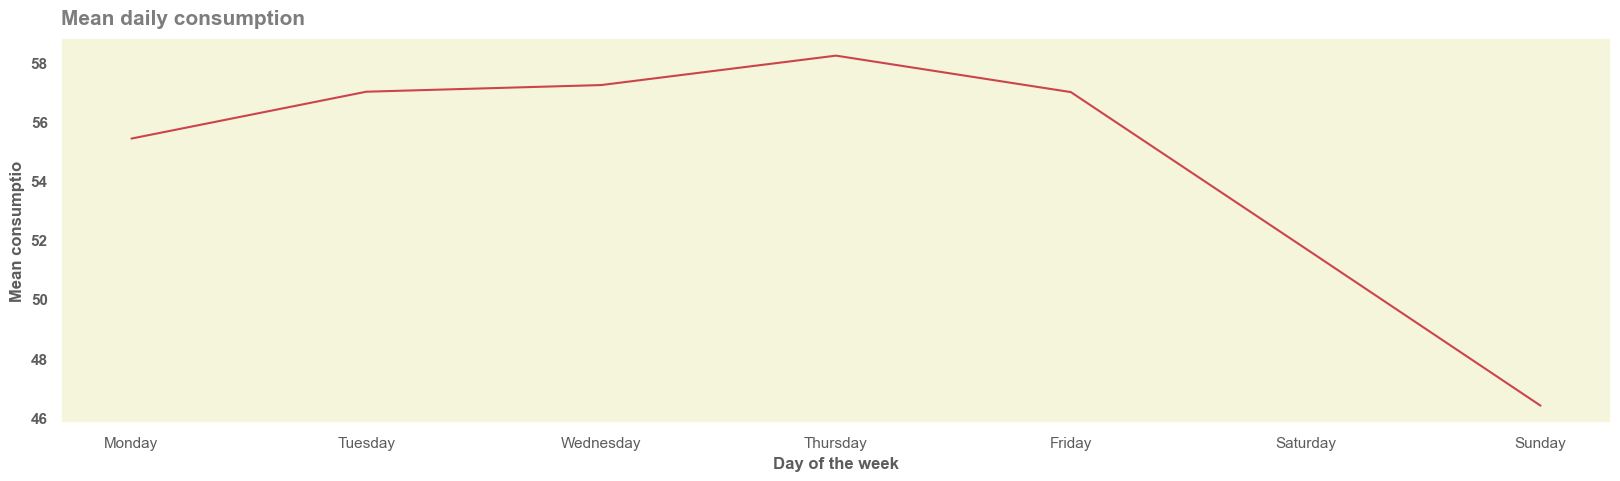

In [58]:
df2 = df_Spain1.set_index('Period')
mean_per_day = df2.groupby("Day")["Cost(€/MWh)"].agg(["mean"])
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(mean_per_day.index,mean_per_day["mean"])
plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=0.75)
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Day of the week",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")
plt.title("Mean daily consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10);
del mean_per_day

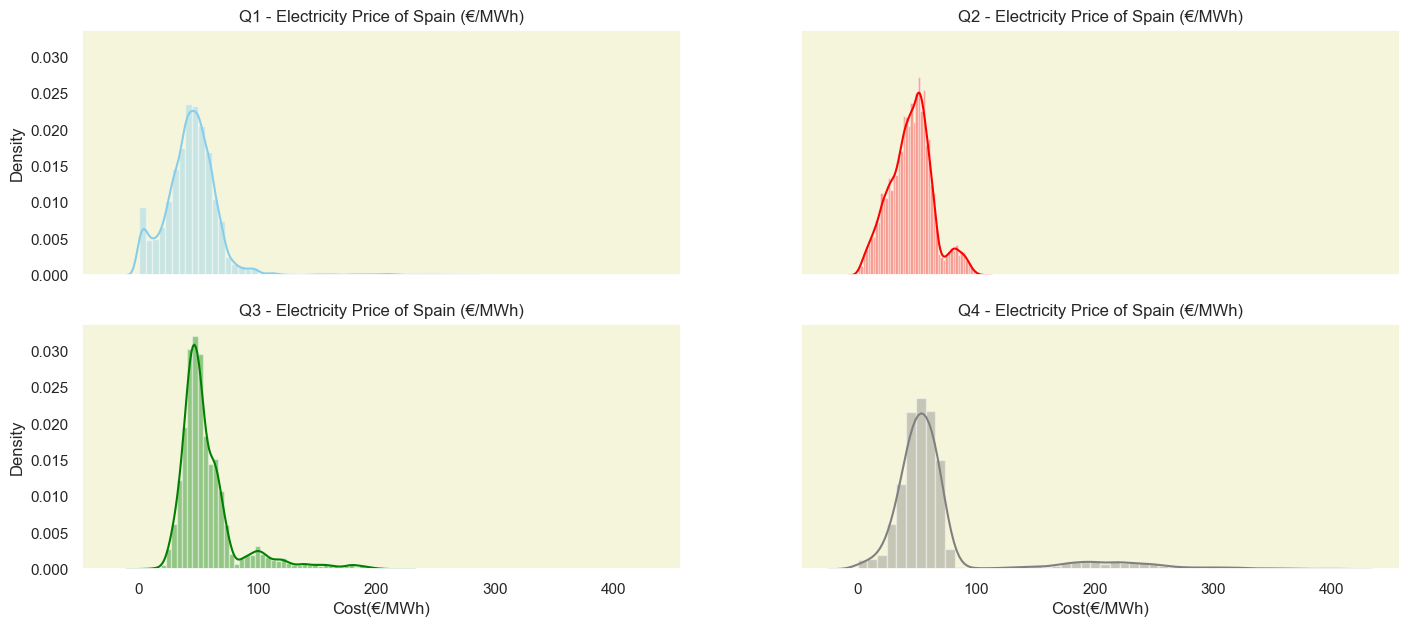

In [56]:
#Data prep
Q1 = df2[df2["quarter"]==1]
Q2 = df2[df2["quarter"]==2]
Q3 = df2[df2["quarter"]==3]
Q4 = df2[df2["quarter"]==4]
#Plot
fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)
sns.distplot(Q1["Cost(€/MWh)"],color="skyblue", ax=axes[0,0]).set_title("Q1 - Electricity Price of Spain (€/MWh)")))
sns.distplot(Q2["Cost(€/MWh)"],color="red", ax=axes[0,1]).set_title("Q2 - Electricity Price of Spain (€/MWh)")
sns.distplot(Q3["Cost(€/MWh)"],color="green", ax=axes[1,0]).set_title("Q3 - Electricity Price of Spain (€/MWh)")
sns.distplot(Q4["Cost(€/MWh)"],color="gray", ax=axes[1,1]).set_title("Q4 - Electricity Price of Spain (€/MWh)")
del Q1, Q2, Q3, Q4

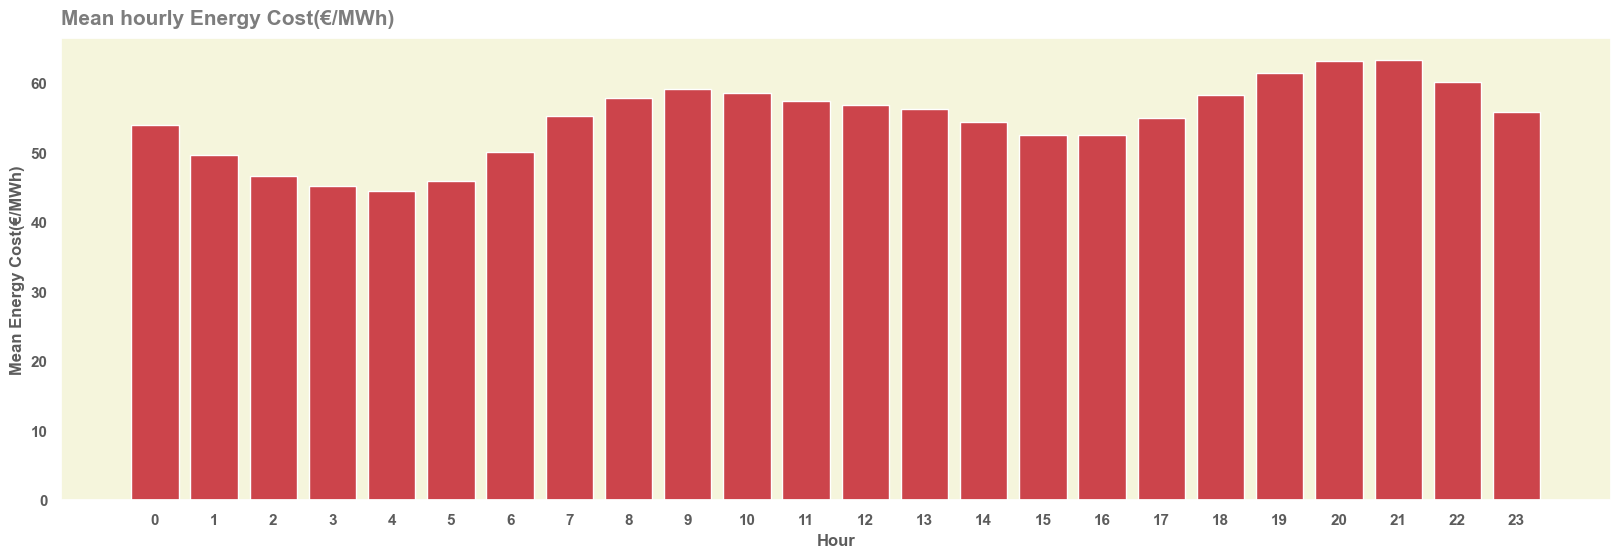

In [59]:
mean_per_hour = df2.groupby("Hour")["Cost(€/MWh)"].agg(["mean"])
fig, ax = plt.subplots(figsize=(20,6))
plt.bar(mean_per_hour.index, mean_per_hour["mean"])
plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean Energy Cost(€/MWh)",alpha=0.75, weight="bold")
plt.title("Mean hourly Energy Cost(€/MWh)", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)
del mean_per_hour

In [60]:
df2 = df2.drop('MonthName',axis=1)
df2.head()

,Cost(€/MWh),year,quarter,month,day,Day,Hour,weekday
Period,,,,,,,,
2014-01-01 00:00:00,20.0200,2014,1,1,1,2,0,1
2014-01-01 01:00:00,10.3400,2014,1,1,1,2,1,1
2014-01-01 02:00:00,5.3500,2014,1,1,1,2,2,1
2014-01-01 03:00:00,5.0000,2014,1,1,1,2,3,1
2014-01-01 04:00:00,0.5000,2014,1,1,1,2,4,1


In [61]:
print('Number of rows and columns:', df_Spain1.shape)
print('Minimum date_time:', df_Spain1.Period.min())
print('Maximum date_time:', df_Spain1.Period.max())
df_Spain1.head(5)

Number of rows and columns: (70296, 10)
Minimum date_time: 2014-01-01 00:00:00
Maximum date_time: 2022-01-08 23:00:00


,Period,Cost(€/MWh),year,quarter,month,day,Day,Hour,MonthName,weekday
0,2014-01-01 00:00:00,20.0200,2014,1,1,1,2,0,January,1
1,2014-01-01 01:00:00,10.3400,2014,1,1,1,2,1,January,1
2,2014-01-01 02:00:00,5.3500,2014,1,1,1,2,2,January,1
3,2014-01-01 03:00:00,5.0000,2014,1,1,1,2,3,January,1
4,2014-01-01 04:00:00,0.5000,2014,1,1,1,2,4,January,1


In [63]:
# Test for Normality of the Global Active Power Data
# Import the required libraries
import scipy.stats as stats
# Calculate the test statistics and p-value
stat, p = stats.normaltest(df_Spain['Cost(€/MWh)'])
# Print the results
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Set the significance level
alpha = 0.05
# Make a decision on the test result
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

Statistics=54725.058, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 18.563754859879868
Skewness of normal distribution: 3.678748967369027


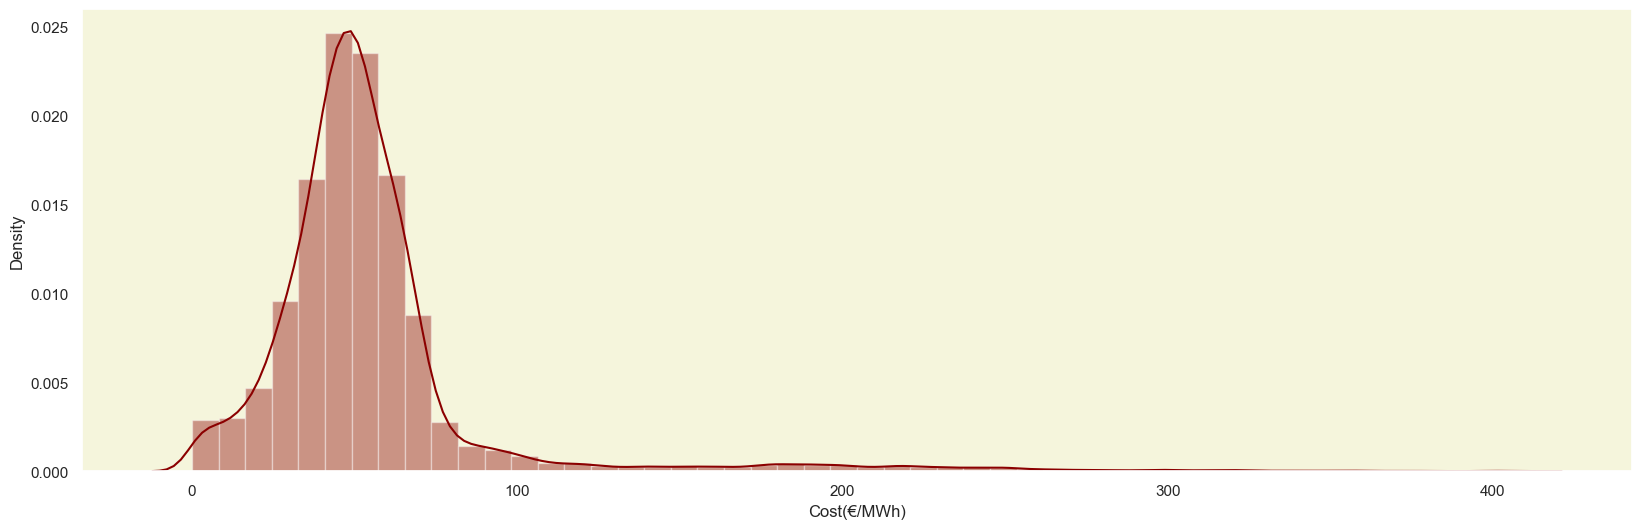

In [64]:
plt.figure(figsize=(20,6))
sns.distplot(df_Spain1['Cost(€/MWh)'],color='darkred')
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_Spain1['Cost(€/MWh)'])))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_Spain1['Cost(€/MWh)'])))

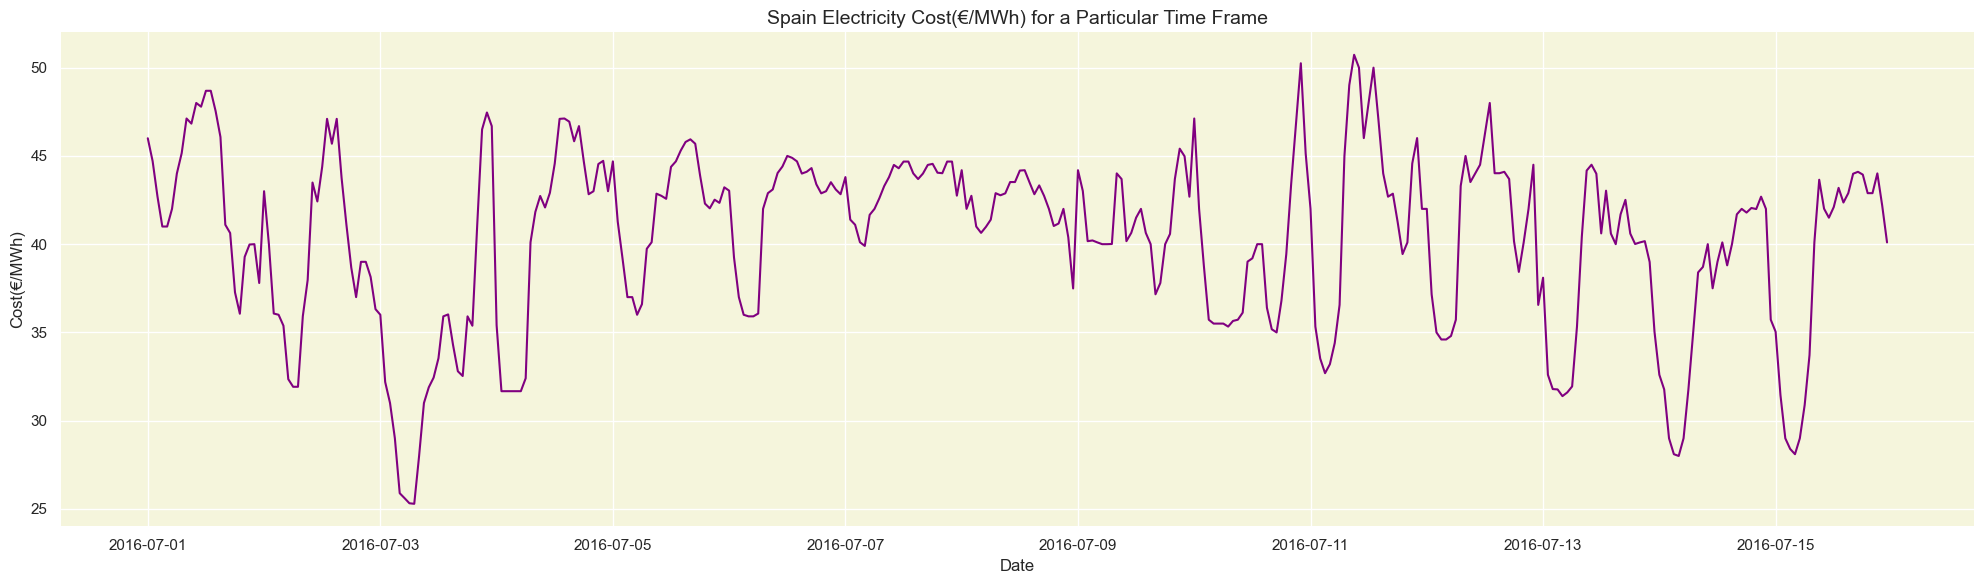

In [65]:
data1 = df_Spain1[(df_Spain1['Period'] >= '2016-07-01') & (df_Spain1['Period'] < '2016-7-16')]
plt.figure(figsize=(20,6))
plt.plot(data1['Period'], data1['Cost(€/MWh)'], color='purple')
plt.ylabel('Cost(€/MWh)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Spain Electricity Cost(€/MWh) for a Particular Time Frame', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()


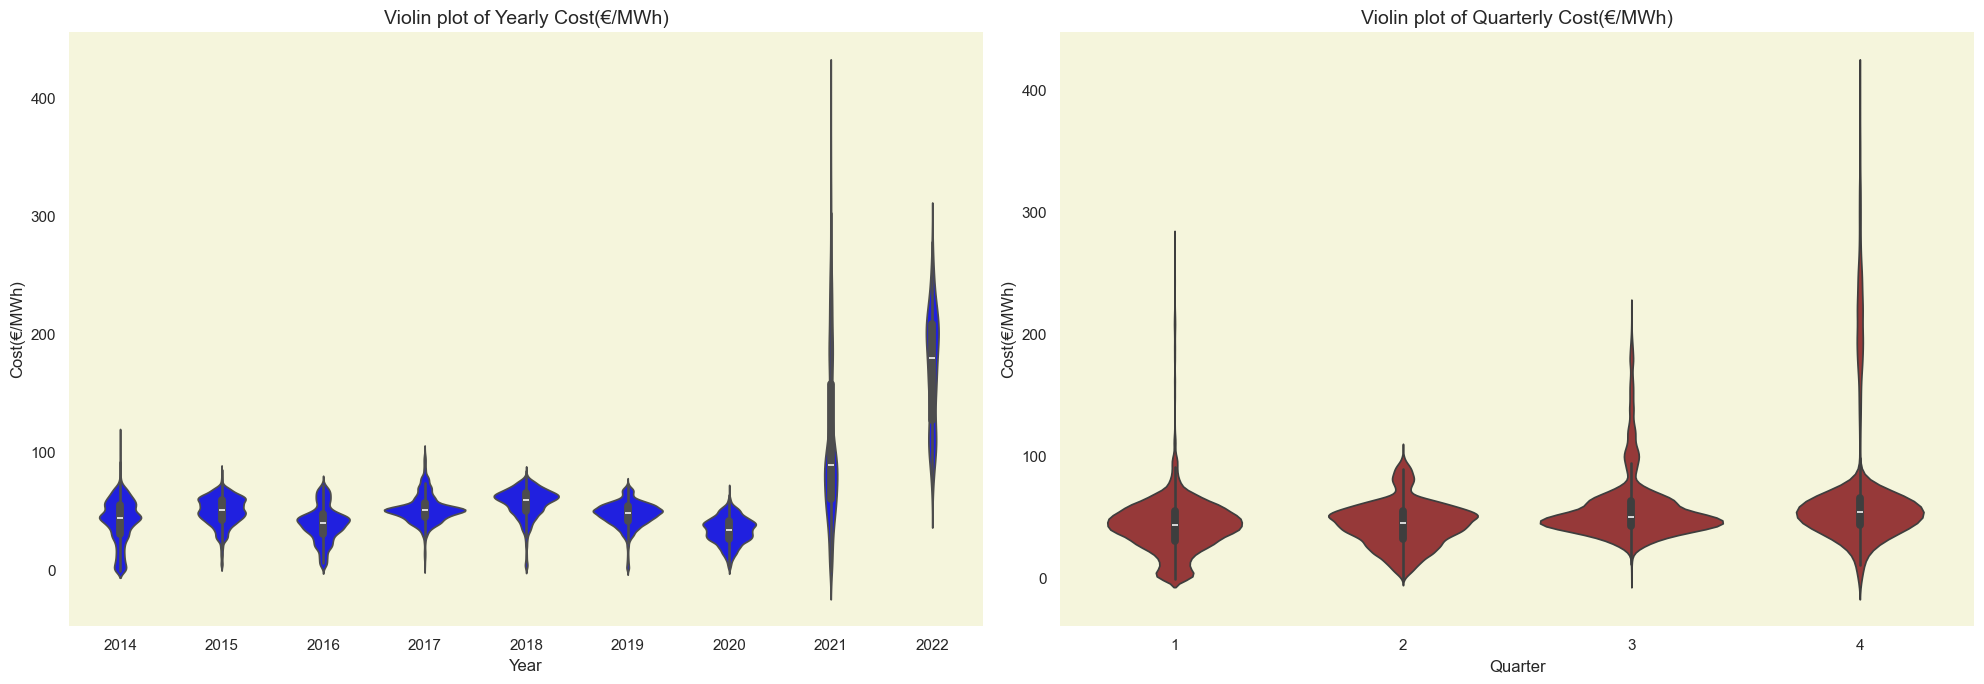

In [66]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.violinplot(x="year", y="Cost(€/MWh)", data=df_Spain1, color='Blue')
plt.xlabel('Year', fontsize=12)
plt.title('Violin plot of Yearly Cost(€/MWh)', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.violinplot(x="quarter", y="Cost(€/MWh)", data=df_Spain1, color='Brown')
plt.xlabel('Quarter', fontsize=12)
plt.title('Violin plot of Quarterly Cost(€/MWh)', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()

Text(0.5, 1.0, 'Normal Probability Plot of Cost(€/MWh)')

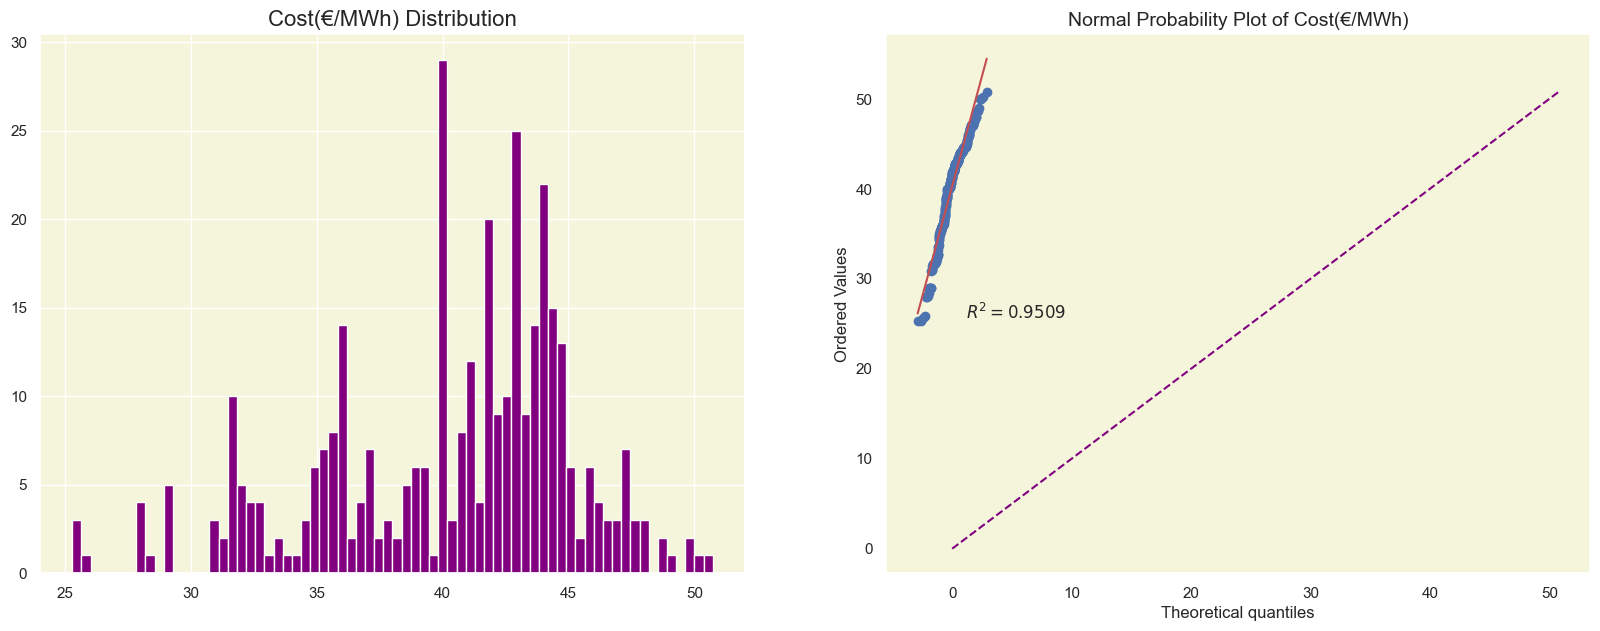

In [68]:
# Plotting the histogram and normal probability plot for 'Global_active_power' column
plt.figure(figsize=(20,7))
# Histogram of 'Global_active_power' column
plt.subplot(1,2,1)
data1['Cost(€/MWh)'].hist(bins=70, color='purple')
plt.title('Cost(€/MWh) Distribution', fontsize=16)
# Normal Probability Plot of 'Cost(€/MWh)' column
plt.subplot(1,2,2)
# Create the normal probability plot using stats.probplot
stats.probplot(data1['Cost(€/MWh)'], plot=plt, fit=True, rvalue=True)
# Add a line to the plot
plt.plot([0, max(data1['Cost(€/MWh)'])], [0, max(data1['Cost(€/MWh)'])], color='purple', linestyle='--')
plt.title('Normal Probability Plot of Cost(€/MWh)', fontsize=14)

In [69]:
data1=df_Spain1.loc[:,['Period','Cost(€/MWh)']]
data1.set_index('Period',inplace=True)
data1.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,20.0200
2014-01-01 01:00:00,10.3400
2014-01-01 02:00:00,5.3500
2014-01-01 03:00:00,5.0000
2014-01-01 04:00:00,0.5000


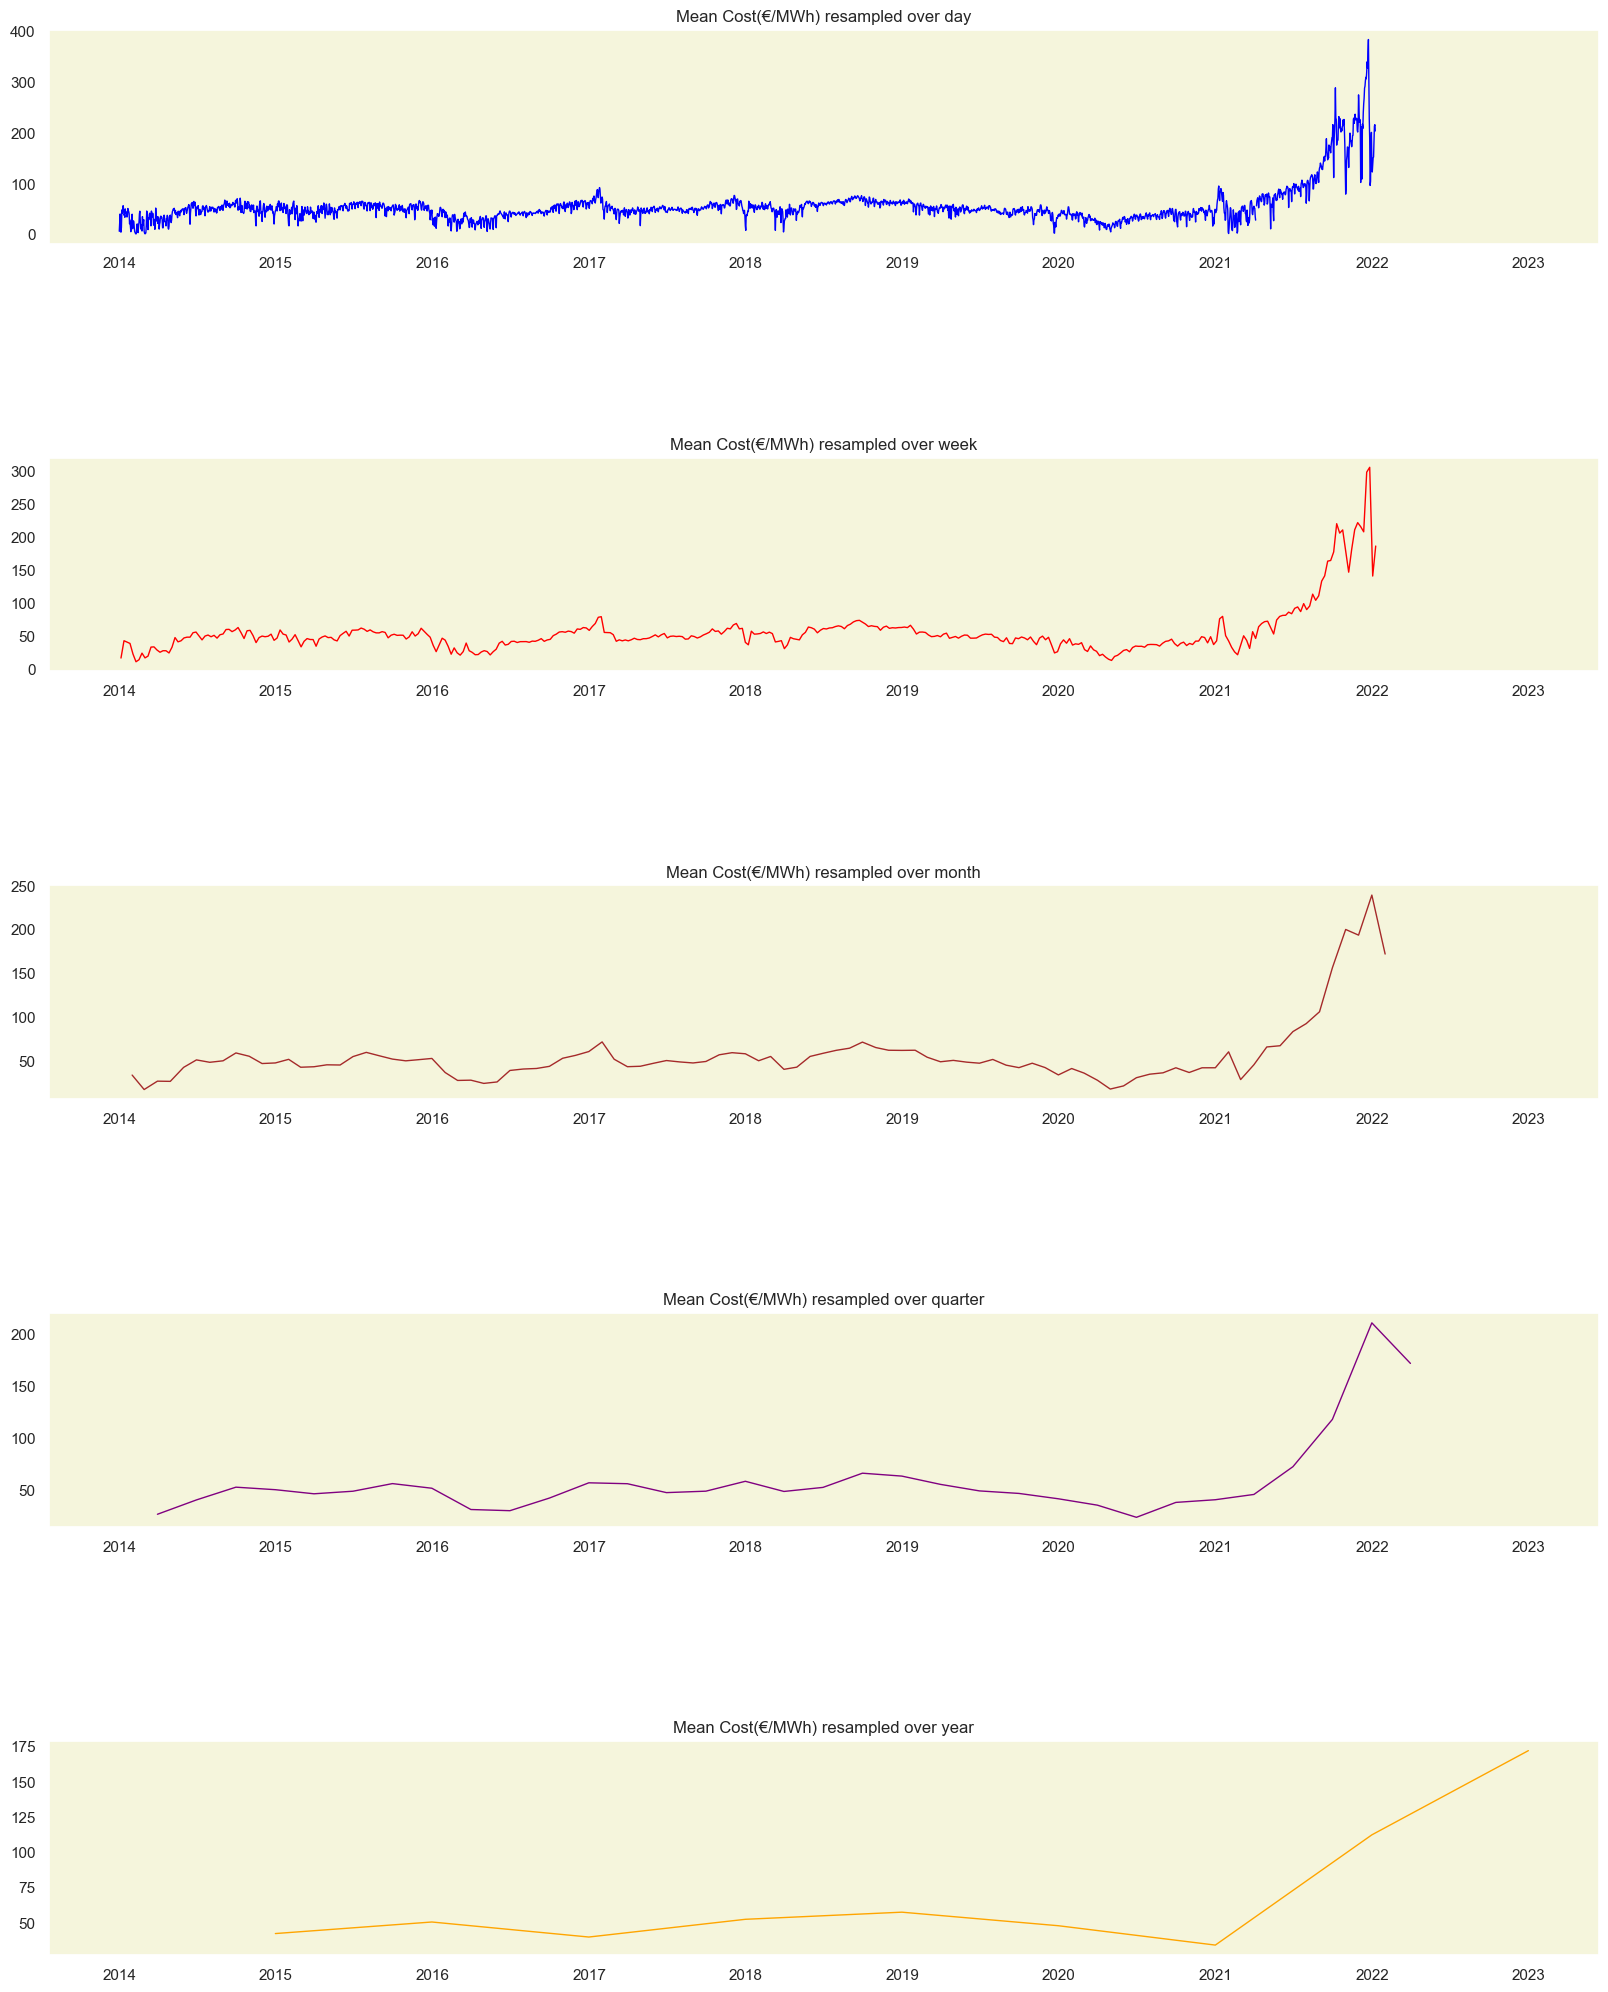

In [71]:
# Create a figure with specified size
fig = plt.figure(figsize=(20,25))
# Adjust the subplot spacing
fig.subplots_adjust(hspace=1)
# Create first subplot
ax1 = fig.add_subplot(5,1,1)
ax1.plot(data1['Cost(€/MWh)'].resample('D').mean(), linewidth=1, color='Blue')
ax1.set_title('Mean Cost(€/MWh) resampled over day')
ax1.tick_params(axis='both', which='major')
# Create second subplot
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(data1['Cost(€/MWh)'].resample('W').mean(), linewidth=1, color='Red')
ax2.set_title('Mean Cost(€/MWh) resampled over week')
ax2.tick_params(axis='both', which='major')
# Create third subplot
ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(data1['Cost(€/MWh)'].resample('M').mean(), linewidth=1, color='Brown')
ax3.set_title('Mean Cost(€/MWh) resampled over month')
ax3.tick_params(axis='both', which='major')
# Create third subplot
ax4 = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(data1['Cost(€/MWh)'].resample('Q').mean(),linewidth=1, color='purple')
ax4.set_title('Mean Cost(€/MWh) resampled over quarter')
ax4.tick_params(axis='both', which='major')
# Create third subplot
ax5 = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(data1['Cost(€/MWh)'].resample('A').mean(),linewidth=1, color='Orange')
ax5.set_title('Mean Cost(€/MWh) resampled over year')
ax5.tick_params(axis='both', which='major')

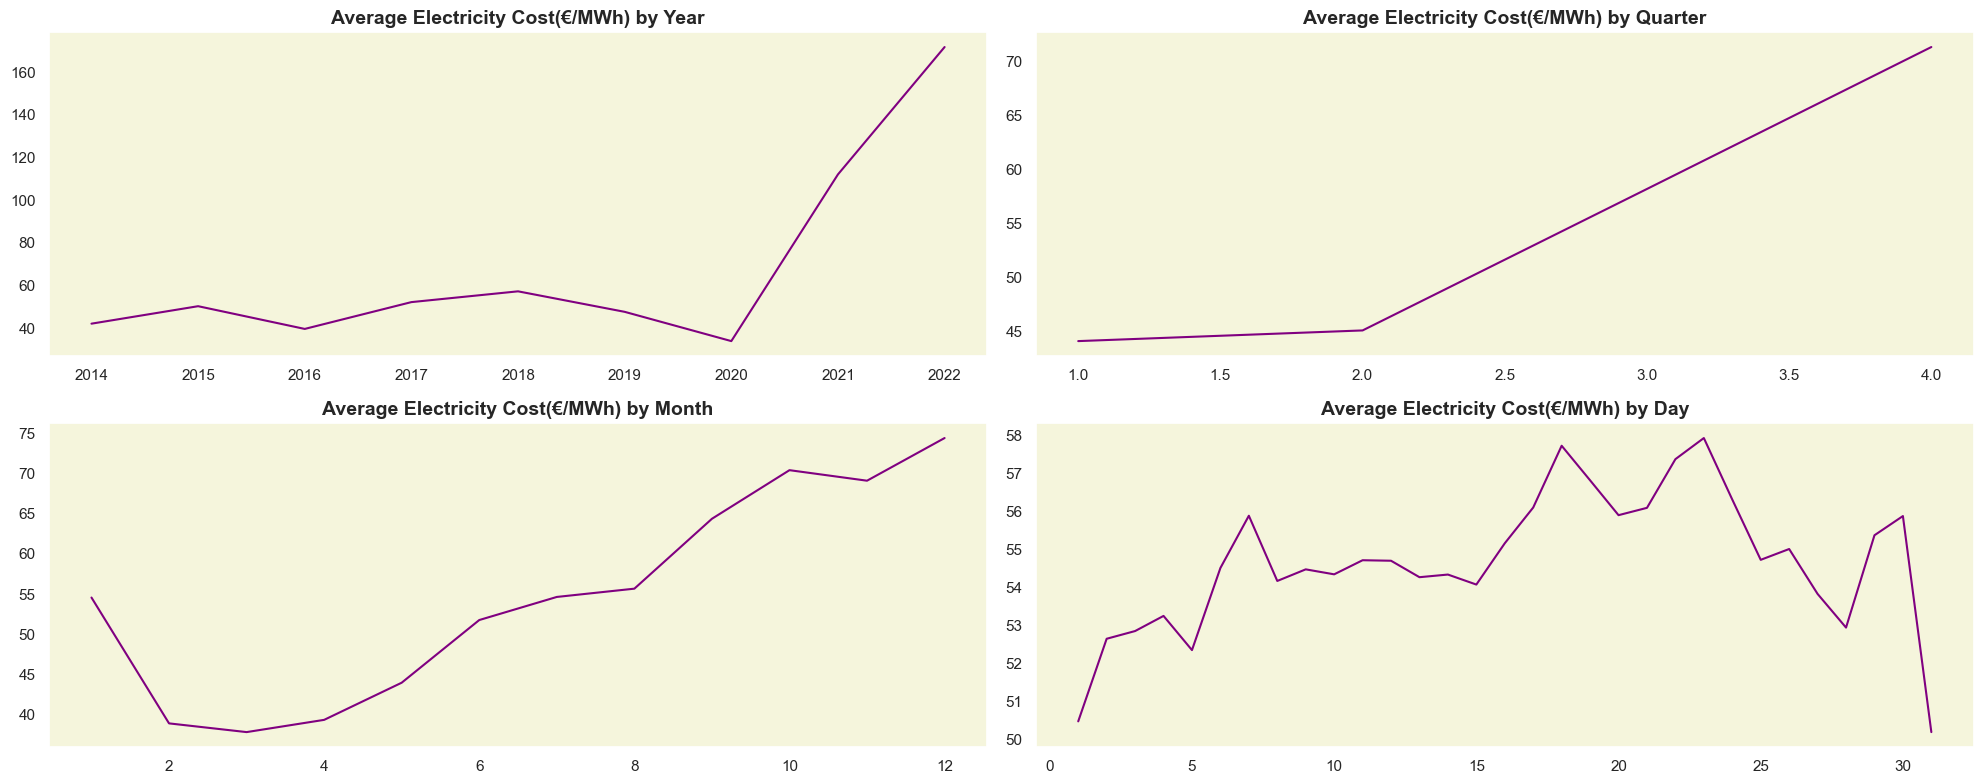

In [72]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
grouped_by_year = df_Spain1.groupby('year')['Cost(€/MWh)'].agg('mean')
grouped_by_year.plot(color='purple')
plt.xlabel('')
plt.title('Average Electricity Cost(€/MWh) by Year', fontsize=14, fontweight='bold')
plt.subplot(2,2,2)
grouped_by_quarter = df_Spain1.groupby('quarter')['Cost(€/MWh)'].agg('mean')
grouped_by_quarter.plot(color='purple')
plt.xlabel('')
plt.title('Average Electricity Cost(€/MWh) by Quarter', fontsize=14, fontweight='bold')
plt.subplot(2,2,3)
grouped_by_month = df_Spain1.groupby('month')['Cost(€/MWh)'].agg('mean')
grouped_by_month.plot(color='purple')
plt.xlabel('')
plt.title('Average Electricity Cost(€/MWh) by Month', fontsize=14, fontweight='bold')
plt.subplot(2,2,4)
grouped_by_day = df_Spain1.groupby('day')['Cost(€/MWh)'].agg('mean')
grouped_by_day.plot(color='purple')
plt.xlabel('')
plt.title('Average Electricity Cost(€/MWh) by Day', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Dickey-Fuller test statistical test to determine the stationarity of a time series:

The Dickey-Fuller test is used to test the null hypothesis that a unit root is present in a time series, which means it is nonstationary and has some time-dependent structure. On the other hand, the alternative hypothesis is that the time series doe 
not have a unit root, meaning it is stationary and does not have time-dependent structur
e.
In the Dickey-Fuller test, if the p-value is greater than 0.05, it means we accept the null hypothesis and the data is considered to
be non-stationary. However, if the p-value is less than or equal to 0.05, we reject the null hypothesis and the data is considered
to be statio
nary.
While LSTM models do not require stationarity of the data, a stationary series with constant mean and variance over time can
result in better performance and make it easier for the neural network to learn.

In [74]:
def test_stationarity(timeseries):
# Calculate rolling mean and standard deviation
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    # Plot original timeseries, rolling mean, and rolling standard deviation
    plt.figure(figsize=(20,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='purple',label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='cyan', label = 'Rolling Std')
    # Add legend
    plt.legend(loc='best')
# Add title
    plt.title('Rolling Mean & Standard Deviation of Cost(€/MWh)')
    plt.show()
# Perform and display results of Dickey-Fuller test
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

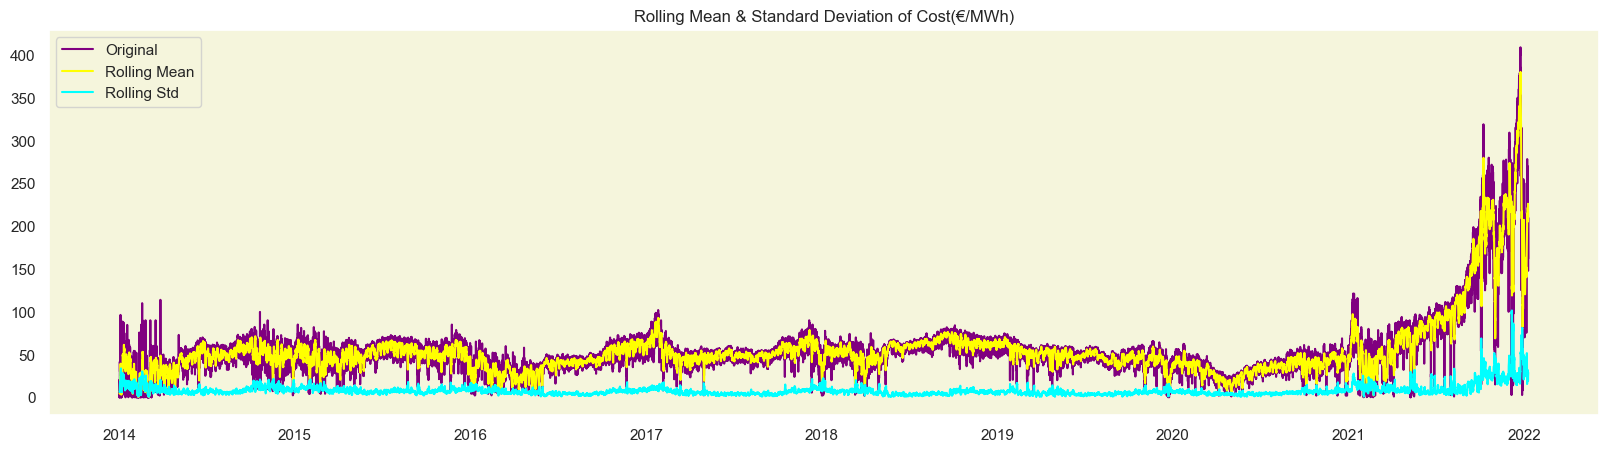

<Results of Dickey-Fuller Test>
Test Statistic                   -5.7593
p-value                           0.0000
#Lags Used                       59.0000
Number of Observations Used   70236.0000
Critical Value (1%)              -3.4304
dtype: float64
Test Statistic                   -5.7593
p-value                           0.0000
#Lags Used                       59.0000
Number of Observations Used   70236.0000
Critical Value (1%)              -3.4304
Critical Value (5%)              -2.8616
dtype: float64
Test Statistic                   -5.7593
p-value                           0.0000
#Lags Used                       59.0000
Number of Observations Used   70236.0000
Critical Value (1%)              -3.4304
Critical Value (5%)              -2.8616
Critical Value (10%)             -2.5668
dtype: float64


In [75]:
test_stationarity(data1['Cost(€/MWh)'].dropna())

The null hypothesis, which suggests the presence of a unit root and therefore non-stationarity in the time series, can be rejected based
on the results of the Dickey-Fuller test.


This implies that the data does not have a time-dependent structure and is stationary.
In this task, the goal is to predict the power consumption of a household for a time series, based on the history of 2 million minutes of
consumption data.


To accomplish this, we will use a multi-layer LSTM recurrent neural network. To ensure that the model provides an accurate prediction,
the data will be kept 
at its original minute-level resolution, instead of being resampled to a lower frequency such as hours.


MODELLING AND EVALUATION 

In [77]:
dataset = df_Spain['Cost(€/MWh)'].values.astype('float32')
#Reshape the numpy array into a 2D array with 1 column
dataset = np.reshape(dataset, (-1, 1))
#Create an instance of the MinMaxScaler class to scale the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
#Fit the MinMaxScaler to the transformed data and transform the values
dataset = scaler.fit_transform(dataset)
#Split the transformed data into a training set (80%) and a test set (20%)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [84]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
       a = dataset[i:(i+look_back), 0]
       X.append(a)
       Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [85]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [86]:
print(X_train.shape)
print(Y_train.shape)

(56205, 30)
(56205,)


In [87]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape

(56205, 1, 30)

LSTM Model :1

In [88]:
# Defining the LSTM model
model = Sequential()
# Adding the first layer with 100 LSTM units and input shape of the data
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.2))
# Adding a dense layer with 1 unit to make predictions
model.add(Dense(1))
# Compiling the model with mean squared error as the loss function and using Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
# Fitting the model on training data and using early stopping to avoid overfitting
history = model.fit(X_train, Y_train, epochs=20, batch_size=1240, validation_data=(X_test, Y_test),
callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)
# Displaying a summary of the model
model.summary()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.4014e-04 - val_loss: 0.0024
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3821e-04 - val_loss: 0.0020
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.4973e-04 - val_loss: 0.0015
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.5883e-04 - val_loss: 0.0012
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.8185e-04 - val_loss: 0.0010
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.2922e-04 - val_loss: 8.8433e-04
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8916e-04 - val_loss: 8.3937e-04
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6931e-04 - val_loss: 9.2781e-04
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5268e-04 - val_loss: 0.0010
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3970e-04 - val_loss: 9.8644e-04
Epoch 1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          52,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,505 (615.26 KB)

 Trainable params: 52,501 (205.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,004 (410.18 KB)

In [89]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

1757/1757 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Train Mean Absolute Error: 4.834919479172759
Train Root Mean Squared Error: 5.885101740089512
Test Mean Absolute Error: 8.29348548441931
Test Root Mean Squared Error: 12.203908816654291


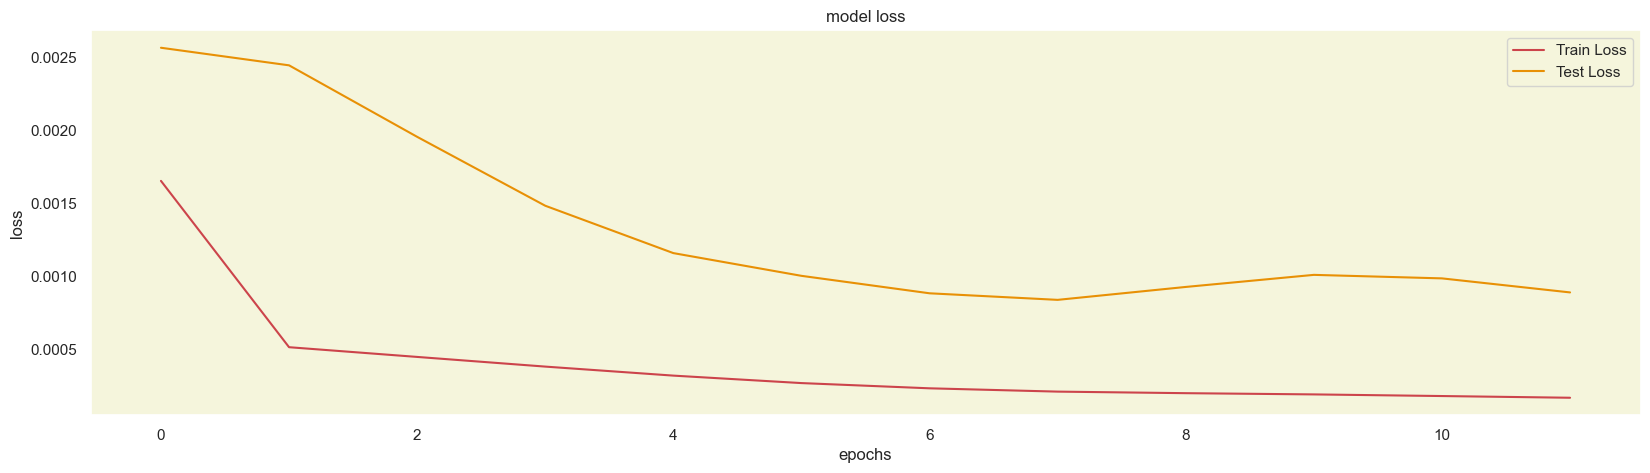

In [90]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

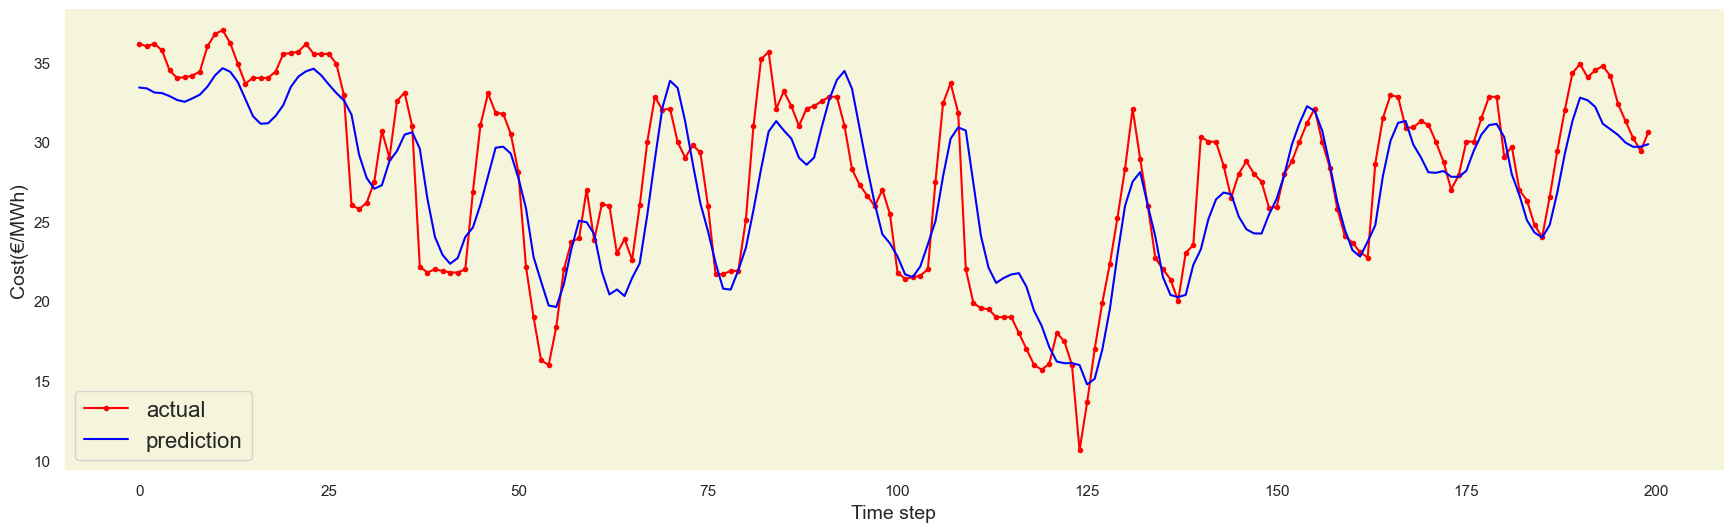

In [91]:
aa=[x for x in range(200)]
# Creating a figure object with desired figure size
plt.figure(figsize=(20,6))
# Plotting the actual values in blue with a dot marker
plt.plot(aa, Y_test[0][:200], marker='.', label="actual", color='Red')
# Plotting the predicted values in green with a solid line
plt.plot(aa, test_predict[:,0][:200], '-', label="prediction", color='Blue')
# Removing the top spines
sns.despine(top=True)
# Adjusting the subplot location
plt.subplots_adjust(left=0.07)
# Labeling the y-axis
plt.ylabel('Cost(€/MWh)', size=14)
# Labeling the x-axis
plt.xlabel('Time step', size=14)
# Adding a legend with font size of 15
plt.legend(fontsize=16)
# Display the plot
plt.show()